# Classification des Sentiments des Tweets Aériens

lien du dataset: https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

# Scikit-learn
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# TensorFlow et Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, LSTM, GRU, Dense, Dropout
)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Transformers (Hugging Face)
from transformers import (
    BertTokenizer, TFBertForSequenceClassification
)


In [ ]:
df = pd.read_csv("/content/Tweets.csv")

In [ ]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
df = df[['text', 'airline_sentiment']]
df.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


# **Préparation des données**


In [ ]:
# Supprimer les neutres
df = df[df['airline_sentiment'] != 'neutral']

In [ ]:
# Convertir les labels en entiers : 0 = negative 1 = positive
df['label'] = df['airline_sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [ ]:
print("Répartition des classes :")
print(df['label'].value_counts())

Répartition des classes :
label
0    9178
1    2363
Name: count, dtype: int64


In [ ]:
# Séparer les classes
df_positive = df[df['airline_sentiment'] == 'positive']
df_negative = df[df['airline_sentiment'] == 'negative']

# Réduire la classe majoritaire
df_negative_downsampled = resample(df_negative, replace=False, n_samples=len(df_positive), random_state=42)

# Fusionner les deux classes équilibrées
df = pd.concat([df_positive, df_negative_downsampled])

# Vérifier l'équilibre
print(df['airline_sentiment'].value_counts())

airline_sentiment
positive    2363
negative    2363
Name: count, dtype: int64


In [ ]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/590.6 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 583.7/590.6 kB 20.4 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 13.9 MB/s eta 0:00:00


In [ ]:
import emoji
def clean_text(text):
    text = text.lower()
    text = re.sub(r'@\w+', '', text)  # Supprimer les mentions
    text = re.sub(r'http\S+', '', text)  # Supprimer les URL
    text = re.sub(r'#\w+', '', text)  # Supprimer les hashtags
    text = text.translate(str.maketrans('', '', string.punctuation))  # Supprimer la ponctuation
    text = emoji.replace_emoji(text, replace="")  # Supprimer les emojis
    text = re.sub(r'\s+', ' ', text).strip()  # Supprimer les espaces multiples
    return text

df['clean_text'] = df['text'].apply(clean_text)
df[['text', 'clean_text']].head(100)

,text,clean_text
1,@VirginAmerica plus you've added commercials t...,plus youve added commercials to the experience...
6,"@VirginAmerica yes, nearly every time I fly VX...",yes nearly every time i fly vx this “ear worm”...
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",well i didnt…but now i do d
9,"@VirginAmerica it was amazing, and arrived an ...",it was amazing and arrived an hour early youre...
11,@VirginAmerica I &lt;3 pretty graphics. so muc...,i lt3 pretty graphics so much better than mini...
...,...,...
333,@VirginAmerica Thanks for the lovely soft view...,thanks for the lovely soft views to
341,"@VirginAmerica I adore you, and am so looking ...",i adore you and am so looking forward to my fl...
342,@VirginAmerica I was so glad it was mentioned....,i was so glad it was mentioned i took my first...
347,"@VirginAmerica first time flying Virgin, went ...",first time flying virgin went to thanks for th...


In [ ]:
# Séparer les données en train/test
train_texts, test_texts, train_labels, test_labels = train_test_split(df["text"], df["label"],
                                                                      test_size=0.2, random_state=42,
                                                                      stratify=df["label"])

In [ ]:
# Tokenizer
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)

In [ ]:
# Convertir les tweets en séquences
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

In [ ]:
# Définir une longueur de séquence maximale
MAX_LENGTH = max([len(x) for x in train_sequences])

In [ ]:
# Appliquer le padding
X_train = pad_sequences(train_sequences, maxlen=MAX_LENGTH, padding="post")
X_test = pad_sequences(test_sequences, maxlen=MAX_LENGTH, padding="post")

y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [ ]:
# Paramètres
MAX_VOCAB = 30000
MAX_LENGTH = 50
EMBEDDING_DIM = 200
BATCH_SIZE = 64
EPOCHS = 10

# **LSTM Model**


In [ ]:
lstm_model = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=EMBEDDING_DIM, input_length=MAX_LENGTH),
    LSTM(128, return_sequences=False),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.5993 - loss: 0.6152 - val_accuracy: 0.8626 - val_loss: 0.3523
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9283 - loss: 0.2088 - val_accuracy: 0.8605 - val_loss: 0.3126
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9571 - loss: 0.1310 - val_accuracy: 0.8140 - val_loss: 0.5114
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9665 - loss: 0.1197 - val_accuracy: 0.8393 - val_loss: 0.5317
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9790 - loss: 0.0691 - val_accuracy: 0.8636 - val_loss: 0.6173
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9795 - loss: 0.0855 - val_accuracy: 0.8531 - val_loss: 0.4729
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9828 - loss: 0.0754 - val_accuracy: 0.8436 - val_loss: 0.6787
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9758 - loss: 0.1070 - val_accuracy: 0.7854 - v

In [ ]:
# Sauvegarde du modèle complet
lstm_model.save("lstm_model.h5")

# **Attention Layer**

In [ ]:
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(1,), initializer="zeros", trainable=True)

    def call(self, inputs):
        e = tf.nn.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        a = tf.nn.softmax(e, axis=1)
        return tf.reduce_sum(inputs * a, axis=1)

# **GRU + Attention**

In [ ]:
gru_model = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=EMBEDDING_DIM, input_length=MAX_LENGTH),
    GRU(128, return_sequences=True),
    AttentionLayer(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
gru_model.fit(X_train, y_train, epochs=7, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

Epoch 1/7
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6295 - loss: 0.5958 - val_accuracy: 0.8552 - val_loss: 0.3307
Epoch 2/7
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9288 - loss: 0.1976 - val_accuracy: 0.8573 - val_loss: 0.3234
Epoch 3/7
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9674 - loss: 0.0995 - val_accuracy: 0.8784 - val_loss: 0.3491
Epoch 4/7
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9866 - loss: 0.0464 - val_accuracy: 0.8647 - val_loss: 0.4152
Epoch 5/7
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9944 - loss: 0.0244 - val_accuracy: 0.8689 - val_loss: 0.5262
Epoch 6/7
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9807 - loss: 0.0671 - val_accuracy: 0.8541 - val_loss: 0.5499
Epoch 7/7
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9971 - loss: 0.0143 - val_accuracy: 0.8668 - val_loss: 0.4770


In [ ]:
# Sauvegarde du modèle complet
gru_model.save("lstm_model.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


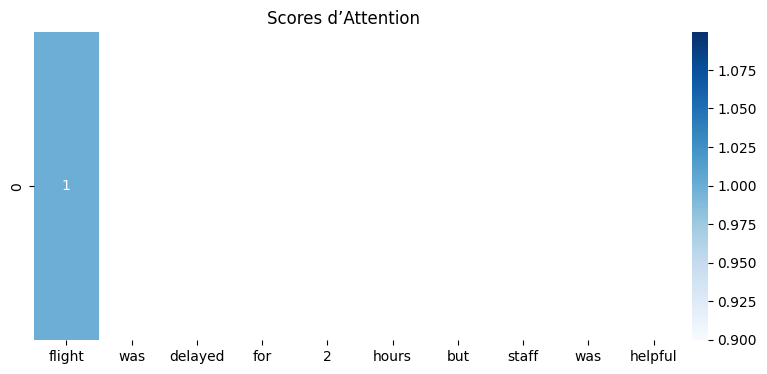

In [ ]:
def plot_attention_weights(sentence):
    tokenized_sentence = tokenizer.texts_to_sequences([sentence])
    padded_sentence = pad_sequences(tokenized_sentence, maxlen=MAX_LENGTH, padding='post')

    attention_weights = gru_model.predict(padded_sentence)
    attention_weights = attention_weights.reshape(-1)

    plt.figure(figsize=(10, 4))
    sns.heatmap([attention_weights], annot=True, xticklabels=sentence.split(), cmap="Blues")
    plt.title("Scores d’Attention")
    plt.show()

# Exemple d’un tweet
plot_attention_weights("flight was delayed for 2 hours but staff was helpful")

# **Transformers**

In [ ]:
from transformers import create_optimizer

# Charger BERT et le tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Préparer les données d'entrée
train_encodings = bert_tokenizer(list(train_texts), truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors="tf")
test_encodings = bert_tokenizer(list(test_texts), truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors="tf")

# Définition des paramètres d'optimisation
batch_size = 16
epochs = 3
num_train_steps = int(len(train_texts) // batch_size * epochs)
num_warmup_steps = int(0.1 * num_train_steps)

# Création de l'optimiseur avec scheduler
optimizer, schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=num_warmup_steps,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01
)

# Compilation du modèle avec l'optimiseur
bert_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Entraînement avec validation
bert_model.fit(
    train_encodings['input_ids'], y_train,
    validation_data=(test_encodings['input_ids'], y_test),
    epochs=3, batch_size=16
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
237/237 [==============================] - 78s 238ms/step - loss: 0.4349 - accuracy: 0.7794 - val_loss: 0.2220 - val_accuracy: 0.9133
Epoch 2/3
237/237 [==============================] - 54s 226ms/step - loss: 0.1513 - accuracy: 0.9484 - val_loss: 0.2022 - val_accuracy: 0.9144
Epoch 3/3
237/237 [==============================] - 52s 219ms/step - loss: 0.0755 - accuracy: 0.9778 - val_loss: 0.1803 - val_accuracy: 0.9355


In [ ]:
# Sauvegarde du modèle complet
bert_model.save("bert_model", save_format="tf")

# **Prediction**

In [ ]:
def predict_sentiment(model, tokenizer, text, max_length=50, threshold=0.5):
    """
    Prend une phrase et prédit si le sentiment est positif ou négatif.
    Arguments :
    - model : modèle de prédiction de sentiment.
    - tokenizer : tokenizer utilisé pour convertir le texte en séquences.
    - text : texte à prédire.
    - max_length : longueur maximale des séquences après padding.
    - threshold : seuil pour déterminer le sentiment (par défaut 0.5).

    Retourne :
    - sentiment : Prédiction du sentiment ('Positive' ou 'Negative').
    - probability : Probabilité du sentiment prédit (proche de 1 pour positif, proche de 0 pour négatif).
    """
    try:
        # Nettoyage du texte
        text = clean_text(text)

        # Tokenization et séquencement
        sequence = tokenizer.texts_to_sequences([text])
        padded_sequence = pad_sequences(sequence, maxlen=max_length, padding="post")

        # Prédiction
        prediction = model.predict(padded_sequence)

        # Interprétation de la prédiction
        probability = prediction[0][0]
        sentiment = "Positive" if probability > threshold else "Negative"

        return sentiment, probability

    except Exception as e:
        # Gestion des erreurs
        print(f"Erreur dans la prédiction du sentiment : {e}")
        return None, None

# Exemple de tests
example_1 = "I love this airline! The service was amazing."
example_2 = "Worst flight ever. Delayed for 5 hours and lost my baggage."

# Tester avec chaque modèle
print("🔹 LSTM:", predict_sentiment(lstm_model, tokenizer, example_1))
print("🔹 GRU avec Attention:", predict_sentiment(gru_model, tokenizer, example_1))
print("🔹 LSTM:", predict_sentiment(lstm_model, tokenizer, example_2))
print("🔹 GRU avec Attention:", predict_sentiment(gru_model, tokenizer, example_2))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
🔹 LSTM: ('Positive', 0.9843317)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
🔹 GRU avec Attention: ('Positive', 0.999962)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
🔹 LSTM: ('Negative', 0.011357468)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
🔹 GRU avec Attention: ('Negative', 1.3407489e-05)


In [ ]:
def predict_sentiment_bert(model, tokenizer, text, max_length=50):
    """
    Prédit le sentiment d'un tweet avec le modèle BERT.
    """
    # Tokenization avec BERT
    encoding = tokenizer(text, truncation=True, padding='max_length', max_length=max_length, return_tensors="tf")

    # Prédiction
    logits = model.predict(encoding["input_ids"])[0]

    # Conversion en probabilités
    probabilities = tf.nn.softmax(logits, axis=-1).numpy()

    # Classe avec la probabilité la plus élevée
    sentiment = "Positive" if np.argmax(probabilities) == 1 else "Negative"
    return sentiment, probabilities

# Exemple de tweets à tester
example_1 = "I love this airline! The service was amazing."
example_2 = "Worst flight ever. Delayed for 5 hours and lost my baggage."
# Tester avec BERT
print("🔹 BERT:", predict_sentiment_bert(bert_model, bert_tokenizer, example_1))
print("🔹 BERT:", predict_sentiment_bert(bert_model, bert_tokenizer, example_2))

1/1 [==============================] - 0s 67ms/step
🔹 BERT: ('Positive', array([[0.0059321, 0.9940679]], dtype=float32))
1/1 [==============================] - 0s 72ms/step
🔹 BERT: ('Negative', array([[0.99352115, 0.00647884]], dtype=float32))
